# Quantum Vortices

In this example, we will implement the Gross–Pitaevskii equation to find the vortex solution for a 2D Bose-Einstein condensate trapped in a harmonic potential. 

The time-independent Gross–Pitaevskii equation is

$i \hbar \frac{\partial \Psi (\mathbf{r},t)}{\partial t} = \left(-\frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r}) + g |\Psi (\mathbf{r},t)|^2 \right) \Psi (\mathbf{r},t) $,

where $\Psi (\mathbf{r},t)$ is the condensate wavefunction, $V(\mathbf{r})$ is an external potential, and $g$ describes interactions between particles.


In order to generate vortices, we have to add a rotational term to the effective Hamiltonian

$\Omega \left( x  p_y  - y p_x \right)$,

where $\Omega$ is the angular velocity, and find the groundstate of the system. This part is tricky because the Hamiltonian depends on the wavefunction so we cannot simply diagonalize it. However, we can use some alternative methods such as imaginary time evolution which simply damps out all the excited states from an arbitrary initial state leaving us with the groundstate only. Numerical generation of vortices is quite challenging so we will use a couple of tricks in this code to help them to emerge.

We proceed as usual by loading the needed libraries, defining the parameters and the Hilbert space and the operators of the system.

In [22]:
using QuantumOptics
using PyPlot 

The first trick we will use is the introduction of a slight asymetry to the harmonic trap

In [23]:
ωx = 1; # harmonic potential frequency x
ωy = (1 + 10^-3); # harmonic potential frequency y, 10^-3 introduces a slight asymetry
m = 1; # mass of an atom
Ω = 0.6; # angular velocity

r = 5 # size of the space

# position Basis
nx=64; bx = PositionBasis(-r, r, nx); # position basis size nx
ny=64; by = PositionBasis(-r, r, ny); # position basis size nx

# momentum Basis
bpx = MomentumBasis(bx);
bpy = MomentumBasis(by);

# position operators in position space
x  =   position(bx)⊗one(by); # position operator
y  =   one(bx)⊗position(by); # position operator

# momentum operators in momentum space
Px = momentum(bpx) ⊗ one(bpy) 
Py = one(bpx) ⊗ momentum(bpy);

To speed up the calculations a little bit, we will also use the split-step method

In [24]:
# composite bases
compbx = bx ⊗ by
compbp = bpx ⊗ bpy

# FFT
Txp = transform(compbx, compbp)
Tpx = transform(compbp, compbx) 

#kinetic Energy
Hkin = Px^2/2m + Py^2/2m # kinetic energy in momentum space

Hkin_FFT = LazyProduct(Txp, Hkin, Tpx) # lazy tensor for the split-step method

# rotation
# lazy prodycts for the split-step method
Hrot_1 = -1*LazyProduct(x,Txp,Py,Tpx)
Hrot_2 = 1*LazyProduct(y,Txp,Px,Tpx)

# harmonic potential
Hhar = 0.5*(ωx^2*x^2+ωy^2*y^2);

Finally, we can prepare initial state and damp all the excited states. The closer we are to the ground state the faster we get to the actual ground state.

In [25]:
#initial state
p1 = 0
p2 = 0
σx = 3
σy = 3

ϕin = gaussianstate(bx, 0, p1, σx)⊗gaussianstate(by, 0, p2, σy)
normalize!(ϕin);

Let's see how the initial state looks like:

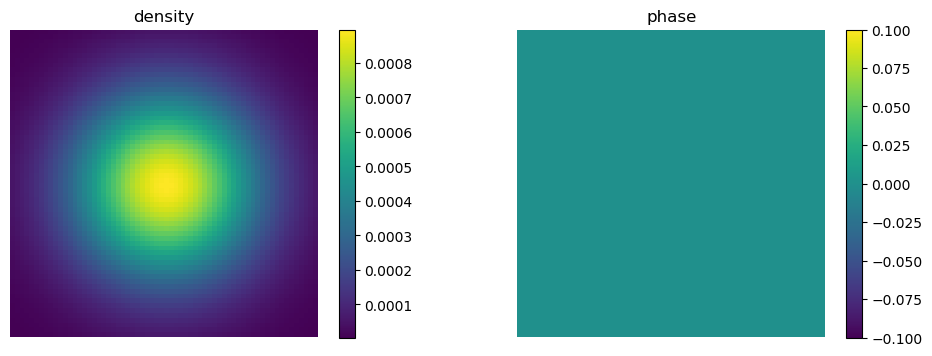

In [26]:
density = Array(transpose(reshape((abs2.(ϕin.data)), (nx, ny))));
phase = Array(transpose(reshape((angle.(ϕin.data)), (nx, ny))));
figure(figsize=(12, 4))
subplot(1,2,1)
title("density")
imshow(density)
colorbar()
axis("off")
subplot(1,2,2)
title("phase")
imshow(phase)
colorbar()
axis("off");

 It is also a good idea to prepare a phase mask for the initial state. We will want to get two vortices so the phase has to jump twice.

In [27]:
mask = Array{Complex{Float64}}(undef, 0)
j = 2 # number of vortices
for x = 1:nx
    for y = 1:ny
        push!(mask,exp(j*1im*atan(x-nx/2,y-ny/2))/2)
    end
end

newstate = (abs.(ϕin.data)).*mask
ϕin = Ket(compbx,newstate);

And see once again the initial state

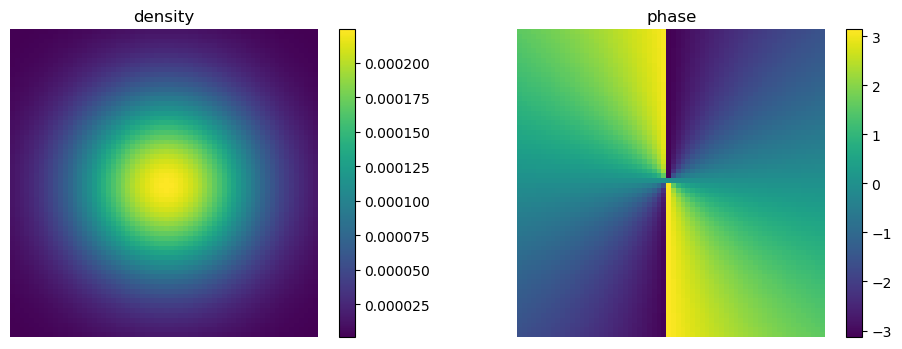

In [28]:
density = Array(transpose(reshape((abs2.(ϕin.data)), (nx, ny))));
phase = Array(transpose(reshape((angle.(ϕin.data)), (nx, ny))));
figure(figsize=(12, 4))
subplot(1,2,1)
title("density")
imshow(density)
colorbar()
axis("off")
subplot(1,2,2)
title("phase")
imshow(phase)
colorbar()
axis("off");

We are now very close to the ground state. Let's kill the contributions from the excited states and get finally nice vortices. Another tricky thing that we have to take into account is the normalization of the wavefunction. In the imaginary time evolution the wavefunction amplitude decreases from step to step. We will normalize the wavefunction after every step.

In [29]:
# GPE 

dx = 2r/nx
g = 100. # interaction strength
Hg = diagonaloperator(bx, Ket(bx).data)⊗diagonaloperator(by, Ket(by).data) # ∝ |ψ|^2

H_tot = -1im*LazySum(Hkin_FFT, Hg, Ω*Hrot_1, Ω*Hrot_2, Hhar) # imaginary time evolution 

function Hgp(t, ψ) # Update state-dependent term in H
    normalize!(ψ) # <- the wavefunction will be always normalized to 1
    H_tot.operators[2].data.nzval .= g*abs2.(ψ.data)/(dx^2) # we need to update the second term in the Hamiltonian
    return H_tot
end

# groundstate  

# imaginary time evolution
T = [0:0.42:4;]
tout, ψt = timeevolution.schroedinger_dynamic(T, ϕin, Hgp; fout = myfout )

# this should be the ground state
ϕ = ψt[end];

Let's also see how the vortices emerged from our intial state

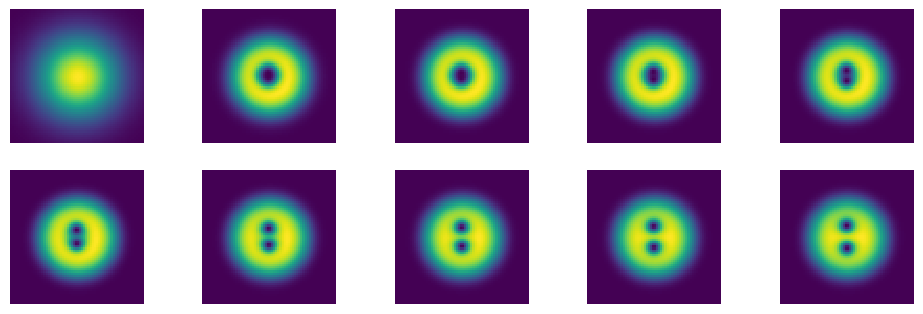

In [30]:
density = [Array(transpose(reshape((abs2.(ψ.data)), (nx, ny)))) for ψ=ψt ];
figure(figsize=(12, 8))
for i = 1:length(ψt)
    subplot(4,5,i)
    imshow(density[i])
    axis("off");
end

And also the phase which should not change too much

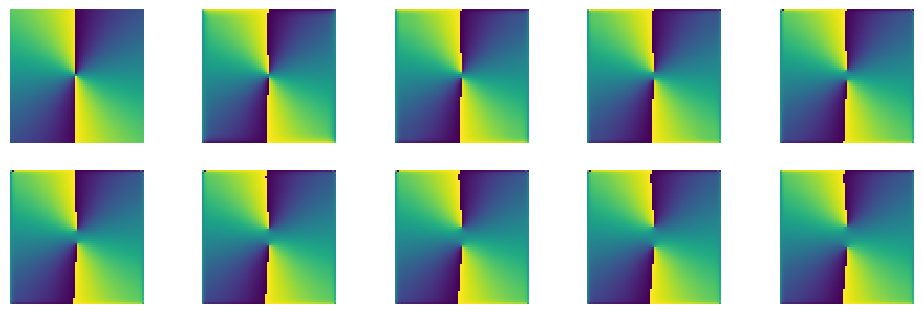

In [31]:
phase = [Array(transpose(reshape((angle.(ψ.data)), (nx, ny)))) for ψ=ψt ];
figure(figsize=(12, 8))
for i = 1:length(ψt)
    subplot(4,5,i)
    imshow(phase[i])
    axis("off");
end